In [ ]:
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 14163 (delta 5), reused 8 (delta 4), pack-reused 14148
Receiving objects: 100% (14163/14163), 12.75 MiB | 6.63 MiB/s, done.
Resolving deltas: 100% (9624/9624), done.


In [ ]:
%cd darknet
!sed -i 's/GPU=0/GPU=1/g' Makefile
!cat Makefile
!make

/content/darknet
GPU=1
CUDNN=0
CUDNN_HALF=0
OPENCV=0
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_30,code=sm_30 \
      -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[sm_61,compute_61]

OS := $(shell uname)

# Tesla A100 (GA100), DGX-A100, RTX 3080
# ARCH= -gencode arch=compute_80,code=[sm_80,compute_80]

# Tesla V100
# ARCH= -gencode arch=compute_70,code=[sm_70,compute_70]

# GeForce RTX 2080 Ti, RTX 2080, RTX 2070, Quadro RTX 8000, Quadro RTX 6000, Quadro RTX 

In [ ]:
import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')
  
DOWNLOAD_LOCATION = '/content/darknet/data/'
DRIVE_DATASET_FILE = '/content/gdrive/My Drive/ml/YOLO_anomaly_new.zip' #adjust path/name of dataset which is in your G-drive

shutil.copy(DRIVE_DATASET_FILE, DOWNLOAD_LOCATION)

print('Successfully downloaded the dataset')

In [ ]:
!unzip data/YOLO_anomaly.zip -d data/ # adjust the dataset filename which you have downloaded from Google drive

Archive:  data/YOLO_anomaly.zip
   creating: data/YOLO_anomaly/img/
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4 - Copy (2).png  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4 - Copy (2).txt  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4 - Copy (3).png  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4 - Copy (3).txt  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4 - Copy.png  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4 - Copy.txt  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4.png  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010348_ch300_1000_4.txt  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010403_ch300_1000_0 - Copy (2).png  
  inflating: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010403_ch

In [ ]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2020-08-05 08:20:33--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M   313KB/s    in 20m 43s 

2020-08-05 08:41:17 (128 KB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



We need to set configurations for Yolo in order to properly train. There are few settings which we need to change in the default yolov3.cfg file.

batch
subdivisions (if you get memory out error, increase this 16, 32 or 64)
max_batches (it should be classes*2000)
steps (it should be 80%, 90% of max_batches)
classes (the number of classes which you are going to train)
filters (the value for filters can be calculated using (classes + 5)x3 )


In [ ]:
!sed -i 's/batch=1/batch=64/g' cfg/yolov3.cfg
!sed -i 's/subdivisions=1/subdivisions=32/g' cfg/yolov3.cfg
!sed -i 's/max_batches = 500200/max_batches = 500/g' cfg/yolov3.cfg
!sed -i 's/steps=400000,450000/steps=300,400/g' cfg/yolov3.cfg
!sed -i 's/classes=80/classes=1/g' cfg/yolov3.cfg
!sed -i 's/filters=255/filters=18/g' cfg/yolov3.cfg
!cat cfg/yolov3.cfg

[net]
# Testing
batch=64
subdivisions=32
# Training
# batch=64
# subdivisions=326
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 1000
policy=steps
steps=800,900
scales=.1,.1

[convolutional]
batch_normalize=1
filters=32
size=3
stride=1
pad=1
activation=leaky

# Downsample

[convolutional]
batch_normalize=1
filters=64
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=32
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=leaky

[convolutional]
batch_normalize=1
filters=128
size=3
stride=1
pad=1
activation=leaky

[shortcut]
from=-3
activation=linear

[convolutional]
ba

In [ ]:
# Only run this cell, if you have already trained the model and have weights and backup files in your Google drive
# (Optional) Download the pretrained weight from Google drive

import os.path
import shutil
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')
  
BACKUP_FOLDER = '/content/darknet/backup'
DRIVE_YOLO_BACKUP = '/content/gdrive/My Drive/ml/yolov3_last.weights'

shutil.copy(DRIVE_YOLO_BACKUP, BACKUP_FOLDER)

print('Successfully fetched the pretrained files for Yolo from Google drive')

Successfully fetched the pretrained files for Yolo from Google drive


In [ ]:
# use the line below to train a fresh model
!./darknet detector train data/YOLO_anomaly/obj.data cfg/yolov3.cfg darknet53.conv.74

# use the line below to retrain your previous saved weight
#!./darknet detector train data/obj.data cfg/yolov3.cfg backup/yolov3_last.weights

Streaming output truncated to the last 5000 lines.

 Wrong annotation: class_id = 2. But class_id should be [from 0 to 0], file: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419010403_ch300_1000_0 - Copy (2).txt 

 Wrong annotation: class_id = 1. But class_id should be [from 0 to 0], file: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419171959_ch300_1000_3 - Copy (2).txt 
 total_bbox = 86228, rewritten_bbox = 0.000000 % 
Can't open label file. (This can be normal only if you use MSCOCO): data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419213844_ch300_1000_3.txt 

 Wrong annotation: class_id = 1. But class_id should be [from 0 to 0], file: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419171959_ch300_1000_3.txt 

 Wrong annotation: class_id = 1. But class_id should be [from 0 to 0], file: data/YOLO_anomaly/img/gather_iDASv3-P11_UTC190419172044_ch300_1000_1 - Copy (3).txt 

 Wrong annotation: class_id = 1. But class_id should be [from 0 to 0], file: data/YOLO_anomaly/img/gather_iDASv3-P1

In [ ]:
!./darknet detector test data/YOLO_anomaly/obj.data cfg/yolov3.cfg backup/yolov3_1000.weights "data/test1.png"

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV isn't used - data augmentation will be slow 
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x

In [ ]:
!./darknet detector test data/YOLO_anomaly/obj.data cfg/yolov3.cfg backup/yolov3_last.weights "data/test4.png"

 CUDA-version: 10010 (10010), GPU count: 1  
 OpenCV isn't used - data augmentation will be slow 
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 32, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x

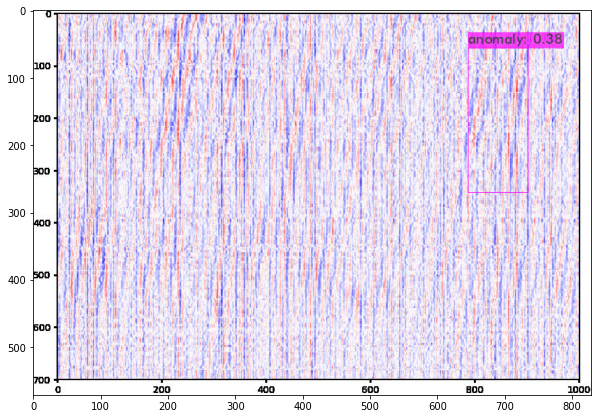

In [ ]:
def display_image(file_path = '/content/darknet/predictions.jpg'):
    import cv2
    import matplotlib.pyplot as plt
    import os.path
    
    if os.path.exists(file_path):
      img = cv2.imread(file_path)
      show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
      plt.figure(figsize=(10,10))
      plt.imshow(show_img)
    else:
      print('failed to open file')
display_image()

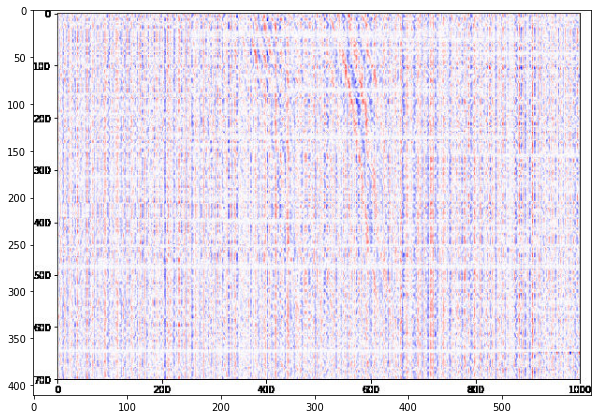

In [ ]:
def display_image(file_path = '/content/darknet/predictions.jpg'):
    import cv2
    import matplotlib.pyplot as plt
    import os.path

    if os.path.exists(file_path):
      img = cv2.imread(file_path)
      show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
      plt.figure(figsize=(10,10))
      plt.imshow(show_img)
    else:
      print('failed to open file')
display_image()

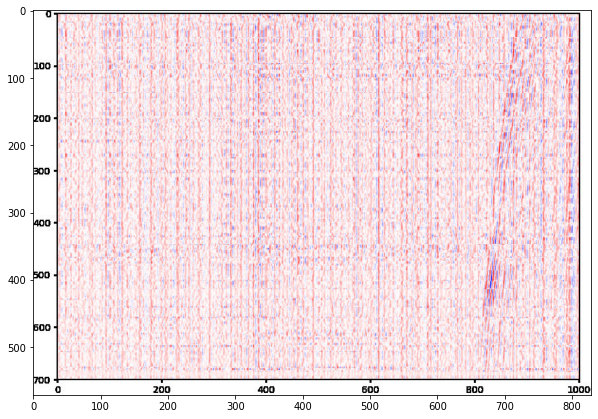

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os.path
img = cv2.imread('/content/darknet/predictions.jpg')
show_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.figure(figsize=(10,10))
plt.imshow(show_img)